# Design of traveltime_lineartime learner

We design a learner to predict Travel Time from the time of day.

## Import Data

In [1]:
# allow importing modules and datafiles up one directory
import os
os.chdir('../')

import pandas as pd
import numpy as np
import datetime
import math
import datatables.traveltime

In [2]:
data = datatables.traveltime.read('data/traveltime.task.train')
data.head()

,id,t,volume,y
0,1,2015-08-19 00:00:00,32.0,660.0
1,2,2015-08-19 00:15:00,20.0,598.0
2,3,2015-08-19 00:30:00,24.0,637.5
3,4,2015-08-19 00:45:00,16.0,637.5
4,5,2015-08-19 01:00:00,9.0,566.0


'y' is travel time in seconds.

## Extract Features

Represent time as a decimal fraction of a day, so that we can more easily use it for prediction.

In [3]:
def frac_day(time):
    """
    Convert time to fraction of a day (0.0 to 1.0)
    Can also pass this function a datetime object    
    """
    return time.hour*(1./24) + time.minute*(1./(24*60)) + time.second*(1./(24*60*60))

We create the features $time^1$, $time^2$, ... in order to allow the regression algorithm to find polynomial fits.

In [4]:
def extract_features(data):
    # Turn list into a n*1 design matrix. At this stage, we only have a single feature in each row.
    t = np.array([frac_day(_t) for _t in data['t']])[:, np.newaxis]
    # Add t^2, t^3, ... to allow polynomial regression
    xs = np.hstack([t, t**2, t**3, t**4, t**5, t**6, t**7, t**8])
    return xs

t = np.array([frac_day(_t) for _t in data['t']])[:, np.newaxis]
xs = extract_features(data)
y = data['y'].values

## Model

Train model, plot regression curve.

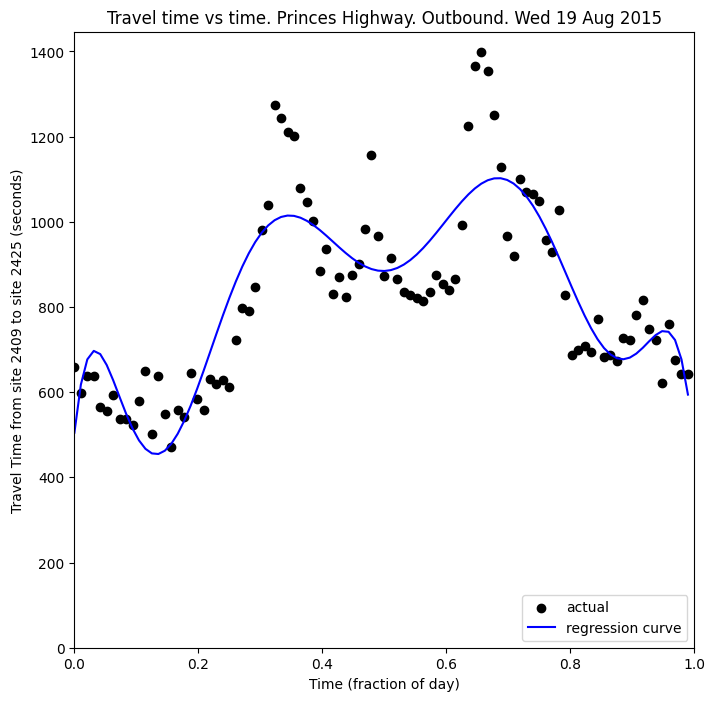

Intercept: 504.85
Coefficients: [ 1.39110198e+04 -3.23004766e+05  2.69673400e+06 -1.06733031e+07
  2.26809948e+07 -2.66087817e+07  1.62400010e+07 -4.02659429e+06]
R^2 score: 0.73


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(xs, y)
y_pred = regr.predict(xs)

plt.figure(figsize=(8,8))
plt.scatter(t, y, color='black', label='actual')
plt.plot(t, y_pred, color='blue', label='regression curve')

plt.title("Travel time vs time. Princes Highway. Outbound. Wed 19 Aug 2015")
plt.ylabel("Travel Time from site 2409 to site 2425 (seconds)")
plt.xlabel("Time (fraction of day)")
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,None])
plt.show()

# http://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares
print('Intercept: %.2f' % regr.intercept_)
print('Coefficients: %s' % regr.coef_)
print('R^2 score: %.2f' % regr.score(xs, y))

## Evaluate

In [6]:
test = datatables.traveltime.read('data/traveltime.task.test') # Traffic on Wed 27 Aug 2015
test_xs = extract_features(test)
test['pred'] = regr.predict(test_xs)
test['error'] = test['y'] - test['pred']
# todo: ensure data is a real number (complex numbers could be used to cheat)
rms_error = math.sqrt(sum(test['error']**2) / len(data))

In [7]:
test.head()

,id,t,volume,y,pred,error
0,98,2015-08-26 00:00:00,23.0,615.0,504.846507,110.153493
1,99,2015-08-26 00:15:00,40.0,628.0,617.629852,10.370148
2,100,2015-08-26 00:30:00,25.0,643.5,676.927136,-33.427136
3,101,2015-08-26 00:45:00,18.0,648.5,696.902103,-48.402103
4,102,2015-08-26 01:00:00,8.0,685.0,689.318902,-4.318902


In [8]:
rms_error

138.24426591216277